In [ ]:
! pip install open-deep-research==0.0.1

In [2]:
from open_deep_research.graph import builder

ModuleNotFoundError: No module named 'src'

In [96]:
from IPython.display import Image, display

from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver

[autoreload of openai.resources.chat.chat failed: Traceback (most recent call last):
  File "/Users/rlm/Desktop/Code/report_mAIstro/report-maistro-env/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/rlm/Desktop/Code/report_mAIstro/report-maistro-env/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/importlib/__init__.py", line 129, in reload
    _bootstrap._exec(spec, module)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 1026, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/Users/rlm/Desktop/Code/report_mAIstro/report-maistro

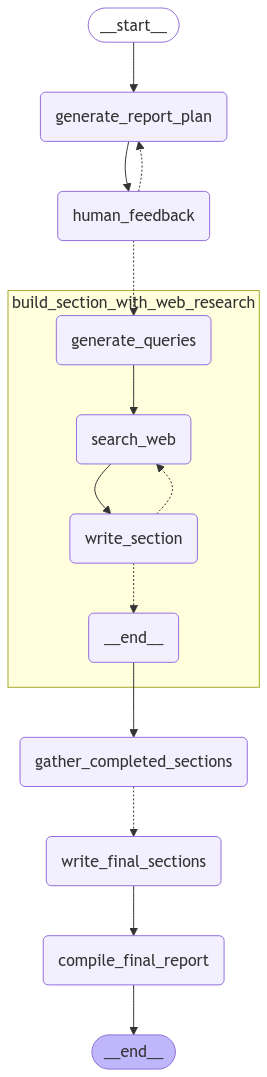

In [85]:



memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [91]:
import uuid 

# Fast config with DeepSeek-R1-Distill-Llama-70B
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "groq",
                           "max_search_depth": 1,
                           "planner_model": "deepseek-r1-distill-llama-70b"}}

# Slow config, more in depth
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "perplexity",
                           "planner_provider": "openai",
                           "max_search_depth": 2,
                           "planner_model": "o3-mini"}}

# Fast config with o3-mini
thread = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "planner_provider": "openai",
                           "max_search_depth": 1,
                           "planner_model": "o3-mini"}}

# Create a topic
topic = "Overview of the AI inference market with focus on Fireworks, Together.ai, Groq"

# Run the graph until the interruption
async for event in graph.astream({"topic":topic,}, thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

Please provide feedback on the following report plan. 

Section: Introduction
Description: Provides a brief overview of the AI inference market and introduces the companies: Fireworks AI, Together.ai, and Groq.
Research needed: No


Section: Market Overview
Description: Examines the overall AI inference market including market trends, key drivers, and competitive landscape.
Research needed: Yes


Section: Fireworks AI Analysis
Description: Delivers an in-depth look at Fireworks AI, including its technology, pricing, market positioning, and comparisons drawn from user reviews and other sources.
Research needed: Yes


Section: Together.ai Analysis
Description: Provides a detailed exploration of Together.ai, covering its platform features, pricing structure, developer tools, and competitive positioning.
Research needed: Yes


Section: Groq Analysis
Description: Focuses on Groq's offering, emphasizing its real-time inference technology, pricing strategy, funding news, and how it challenges existing market leaders.
Research needed: Yes


Section: Comparative Analysis and Future Trends
Description: Offers a side-by-side comparison of Fireworks AI, Together.ai, and Groq, highlighting strengths, weaknesses, and potential future trends in the AI inference market.
Research needed: Yes


Section: Conclusion
Description: Summarizes the findings from the report and distills the main points into a concise summary, potentially using a tabulated or listed format.
Research needed: No


 Does the report plan meet your needs? Pass 'true' to approve the report plan or provide feedback to regenerate the report plan:

In [92]:
# Pass feedback to update the report plan  
async for event in graph.astream(Command(resume="Include a revenue estimate (ARR) in the sections focused on Groq, Together.ai, and Fireworks"), thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

{'human_feedback': {'feedback_on_report_plan': 'Include a revenue estimate (ARR) in the sections focused on Groq, Together.ai, and Fireworks'}}


{'generate_report_plan': {'sections': [Section(name='Introduction', description='Provides a brief overview of the AI inference market and introduces the key companies: Fireworks AI, Together.ai, and Groq.', research=False, content=''), Section(name='Market Overview', description='Presents an in-depth look into the AI inference market trends, including demand, growth factors, and competitive landscape.', research=True, content=''), Section(name='Fireworks AI Analysis', description="Examines Fireworks AI's offerings, including its unique features, performance metrics, and comparisons with other competitors.", research=True, content=''), Section(name='Together.ai Analysis', description="Assesses Together.ai's platform, focusing on its performance, pricing models, and integration capabilities within the AI inference space.", research=True, conten

In [93]:
# Pass True to approve the report plan 
async for event in graph.astream(Command(resume=True), thread, stream_mode="updates"):
    print(event)
    print("\n")

{'human_feedback': None}


{'build_section_with_web_research': {'completed_sections': [Section(name='Together.ai Analysis', description="Assesses Together.ai's platform, focusing on its performance, pricing models, and integration capabilities within the AI inference space.", research=True, content="## Together.ai Platform Assessment\n\n**Together.ai stands out for delivering high-performance AI inference at significantly lower costs than major competitors, offering up to 11x cost savings compared to GPT-4 while maintaining competitive performance.** The platform provides access to over 200 open-source models through an OpenAI-compatible API, enabling straightforward migration from proprietary solutions.\n\nThe platform's infrastructure is built on three core capabilities: inference, fine-tuning, and GPU clusters. Their inference engine leverages advanced optimizations like FlashAttention-3 and speculative decoding to achieve up to 4x faster performance compared to traditional platform

In [21]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# AI Inference Market and Key Players Overview

The AI inference market is experiencing explosive growth, projected to expand from $24.6 billion in 2024 to $133.2 billion by 2034. This transformation is being driven by innovative companies developing breakthrough optimization technologies that dramatically improve performance while reducing costs. Among these pioneers, Fireworks AI has demonstrated enterprise-grade reliability by processing 140 billion tokens daily, while Together.ai has achieved 4x faster decoding throughput than traditional solutions. Groq's Language Processing Unit (LPU) has emerged as a particularly disruptive force, offering competitive pricing from $0.05 to $0.99 per million tokens while securing a $2.8 billion valuation.

## Key Players Comparison

| Feature | Fireworks AI | Together.ai | Groq |
|---------|-------------|-------------|------|
| Daily Processing | 140B tokens | 400 tokens/sec | Not disclosed |
| Pricing Range | $0.10-$1.20/M tokens | Custom pricing | $0.05-$0.99/M tokens |
| Key Innovation | Parameter-based pricing | FlashAttention-3 | Language Processing Unit |
| Enterprise Users | Uber, DoorDash | Salesforce, Washington Post | Hunch AI, aiXplain |
| Valuation | $552M | $100M ARR | $2.8B |

These players are reshaping the inference landscape through distinct approaches to optimization and pricing, with each targeting different segments of the rapidly expanding market. Their continued innovation suggests further disruption in the AI infrastructure space.

## Global AI Inference Market Analysis

**The AI inference market is projected to grow from $24.6 billion in 2024 to $133.2 billion by 2034, driven by breakthrough optimization technologies that are dramatically improving performance while reducing costs.** Cloud deployment currently dominates with 55% market share, though on-premises solutions are gaining traction for latency-sensitive and security-focused applications.

NVIDIA maintains market leadership with approximately 80% share of AI chips, while competitors like AMD, Intel, and cloud providers are investing heavily in specialized inference solutions. Recent advances in speculative decoding and compilation techniques have enabled up to 2x higher throughput at 50% lower costs for popular models like Llama and Mixtral.

Key barriers to adoption include:
- High infrastructure costs and unclear ROI
- Data quality and quantity challenges
- Integration complexity with existing systems
- Skills gaps in AI/ML expertise
- Privacy and regulatory concerns

North America leads regional adoption with 38% market share, particularly in financial services and healthcare verticals. Microsoft's implementation of NVIDIA inference solutions for Copilot demonstrates the technology's enterprise readiness.

### Sources
- Restack AI Hardware Analysis 2024: https://www.restack.io/p/hardware-innovations-for-ai-technologies-answer-leading-ai-hardware-companies-2024
- NVIDIA Developer Blog: https://developer.nvidia.com/blog/optimize-ai-inference-performance-with-nvidia-full-stack-solutions/
- Market.us AI Inference Report: https://scoop.market.us/ai-inference-server-market-news/

## Fireworks AI Technical Analysis

**Fireworks AI combines an innovative pricing model with proven enterprise performance, demonstrated by processing 140 billion tokens daily with 99.99% API uptime across 12,000 users.** Their tiered pricing structure scales with usage, starting at $0.10 per million tokens for small models and reaching $1.20 per million tokens for large MoE architectures.

The platform offers specialized pricing for different modalities:
- Text generation with parameter-based pricing ($0.10-$1.20/M tokens)
- Image generation at $0.00013 per step
- Speech-to-text processing from $0.0009 per audio minute
- On-demand GPU deployments ranging from $2.90 to $9.99 per hour

A notable implementation at Sourcegraph showcases the platform's capabilities, where StarCoder deployment doubled code completion acceptance rates while cutting backend latency by 50%. The company's recent $52M Series B funding values it at $552M, with Forbes estimating 2023 revenue at $3M.

Enterprise customers including Uber, DoorDash, and Upwork have adopted Fireworks AI's infrastructure, citing lower costs and reduced latency compared to alternatives. The platform's spending limits increase with usage history, from $50/month to custom enterprise tiers exceeding $50,000/month.

### Sources
- Fireworks AI Blog Spring Update: https://fireworks.ai/blog/spring-update-faster-models-dedicated-deployments-postpaid-pricing
- AWS Case Study: https://aws.amazon.com/solutions/case-studies/fireworks-ai-case-study/
- Funding News: https://www.pymnts.com/news/investment-tracker/2024/fireworks-ai-valued-552-million-dollars-after-new-funding-round/

## Together.ai's Inference Stack Analysis

**Together.ai has revolutionized LLM inference by achieving 4x faster decoding throughput than open-source vLLM through an integrated approach combining hardware optimization and algorithmic innovations.** Their Inference Engine 2.0 demonstrates superior performance by processing over 400 tokens per second on Meta's Llama 3 8B model.

The technical foundation relies on four key innovations:
- FlashAttention-3 optimization achieving 75% GPU utilization
- Custom-built draft models trained beyond 10x Chinchilla optimal
- Advanced speculative decoding combining Medusa and Sequoia techniques
- Quality-preserving quantization matching FP16 precision

A notable case study demonstrates their efficiency at scale: using just two A100 GPUs, Together Lite outperforms vLLM running on eight H100 GPUs by 30% in common inference scenarios. This translates to a 12x cost reduction compared to standard deployments.

The Enterprise Platform builds on these innovations while maintaining SOC 2, GDPR, and HIPAA compliance. Major enterprises including Salesforce and The Washington Post have validated its performance in production environments, contributing to Together.ai reaching $100M ARR within 10 months of launch.

### Sources
- Together Inference Engine 2.0 Announcement: https://www.together.ai/blog/together-inference-engine-2
- Enterprise Platform Security: https://www.togetherplatform.com/security-compliance
- Speculative Decoding Implementation: https://www.together.ai/blog/speculative-decoding-for-high-throughput-long-context-inference

## Groq's Inference Engine Performance and Market Traction

**Groq's Language Processing Unit (LPU) has demonstrated unprecedented inference speeds while achieving significant market validation, with an estimated $3.4 million revenue in 2023 and a $2.8 billion valuation following their August 2024 Series D round.**

The LPU's competitive pricing structure ranges from $0.05 to $0.99 per million tokens, depending on model size and input/output requirements. For example, their Llama 3.3 70B implementation charges $0.59 per million input tokens and $0.79 per million output tokens, positioning them favorably against cloud competitors.

Developer adoption has been robust, with notable implementations including:
- Hunch AI Workspace for rapid prototyping
- aiXplain's real-time inference solutions
- Argonne National Laboratory's research applications
- Embodied's Moxie education robot

The platform offers an OpenAI-compatible API supporting multiple models including Llama 3.3, Mixtral 8x7b, and Gemma 2. Integration options include LangChain compatibility and Retrieval Augmented Generation capabilities, enabling developers to incorporate proprietary data into their applications.

### Sources
- Sacra Company Analysis: https://sacra.com/c/groq/
- Groq Pricing Documentation: https://groq.com/pricing/
- ChipStrat Analysis: https://www.chipstrat.com/p/the-rise-of-groq-slow-then-fast
- Groq API Documentation: https://distilabel.argilla.io/1.2.1/api/llm/groq/

## Market and Provider Analysis Summary

The AI inference market is experiencing rapid growth, projected to reach $133.2 billion by 2034, with cloud deployment currently dominating at 55% market share. Among emerging providers, Fireworks AI, Together.ai, and Groq demonstrate distinct competitive advantages in performance and pricing strategies.

| Provider | Key Differentiator | Performance Metric | Revenue/Valuation |
|----------|-------------------|-------------------|-------------------|
| Fireworks AI | Enterprise-grade reliability | 140B tokens/day, 99.99% uptime | $3M (2023), $552M valuation |
| Together.ai | Advanced optimization stack | 4x faster than vLLM, 400 tokens/sec | $100M ARR |
| Groq | Custom LPU architecture | Industry-leading latency | $3.4M (2023), $2.8B valuation |

These providers are addressing key market barriers through innovative pricing models, ranging from $0.05 to $1.20 per million tokens, while delivering specialized solutions for different modalities and use cases. Their success in attracting major enterprise customers suggests growing market maturity, though NVIDIA's 80% chip market share indicates continued infrastructure dependencies.

In [ ]:
%load_ext autoreload
%autoreload 2

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from langgraph.types import interrupt, Command

from src.open_deep_research.graph import builder
